In [148]:
import argparse
import torch

parser = argparse.ArgumentParser()
parser.add_argument('--subgraph_size', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--dataset', type=str, default='cora', choices=[
    'cora', 'chameleon', 'BlogCatalog', 'flickr'
])
args = parser.parse_args("")

import lib.data.dataloader as dataloader
g = dataloader.load_DGL(args.dataset)
device = "cuda:1" if torch.cuda.is_available() else "cpu"

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [149]:
from ddpm_conditional import Diffusion

diff = Diffusion(
    device=device,
    img_size=args.subgraph_size
)

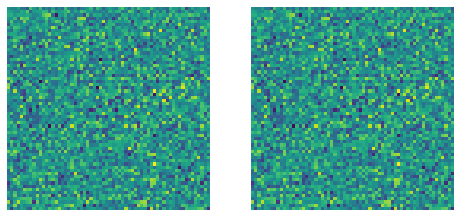

In [150]:
from lib.util.disp import showImages

image = torch.randn([args.subgraph_size, args.subgraph_size])

showImages([image, image])

In [151]:
t = torch.Tensor([50, 100, 150, 200, 300, 600, 700, 999]).long().to(device)
noised = diff.noise_images(image.to(device), t)
noised[0].shape

torch.Size([8, 1, 64, 64])

In [152]:
import importlib
import modules
importlib.reload(modules)

condNet = modules.UNet_conditional(
    args.subgraph_size,
    device=device,
)

feat_embs = torch.randn(3, args.subgraph_size).to(device) # just labels for now
x = torch.randn(3, 1, args.subgraph_size, args.subgraph_size).to(device) # random noise
t = x.new_tensor([500] * 3).long().to(device) # time embedding

print(condNet(x, t, feat_embs).shape)

torch.Size([3, 1, 64, 64])


In [153]:
from typing import Tuple
from torch.utils.data import Dataset
from lib.util.selection import subgraph_cluster

class GraphSamplesDataset(Dataset):
    def __init__(self, graph, subgraph_size, count):
        self.subgraphs = [
            subgraph_cluster(subgraph_size, graph) for i in range(count)
        ]
        
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        sg = self.subgraphs[index]
        
        return ((sg.adj().to_dense().unsqueeze(0)), sg.ndata['label'].float())
    
    def __len__(self):
        return len(self.subgraphs)

from torch.utils.data import DataLoader

dataloader = DataLoader(GraphSamplesDataset(g, args.subgraph_size, args.batch_size * 64), batch_size=args.batch_size, shuffle=True)

# for i, (adj, lab) in enumerate(dataloader):
#     print(adj.shape, lab.shape)
#     print(adj.dtype, lab.dtype)
#     break

In [154]:
from torch import optim
from torch import nn
from tqdm import tqdm
import numpy as np
from modules import EMA
import ddpm_conditional
importlib.reload(ddpm_conditional)

model = modules.UNet_conditional(
    args.subgraph_size,
    device=device
)

diffusion = ddpm_conditional.Diffusion(img_size=args.subgraph_size, 
                                       noise_steps=400,
                                       device=device)

optimizer = optim.AdamW(model.parameters(), lr=1e-2)
mse = nn.MSELoss()
# diffusion = Diffusion(img_size=args.image_size, device=device)
# logger = SummaryWriter(os.path.join("runs", args.run_name))
# l = len(dataloader)
# ema = EMA(0.995)
# ema_model = copy.deepcopy(model).eval().requires_grad_(False)

imgs = []

for epoch in range(10):
    pbar = tqdm(dataloader)
    for i, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        if np.random.random() < 0.1:
            labels = None
        predicted_noise = model(x_t, t, labels)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ema.step_ema(ema_model, model)

        pbar.set_postfix(MSE=loss.item())
        # logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    # if epoch % 10 == 0:
    #     labels = torch.arange(args.subgraph_size).long().to(device)
    #     sampled_images = diffusion.sample(model, n=len(labels), feat_embs=labels)
        # ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
        # plot_images(sampled_images)
        # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        # save_images(ema_sampled_images, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))
        # torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
        # torch.save(ema_model.state_dict(), os.path.join("models", args.run_name, f"ema_ckpt.pt"))
        # torch.save(optimizer.state_dict(), os.path.join("models", args.run_name, f"optim.pt"))

100%|██████████| 64/64 [00:09<00:00,  6.91it/s, MSE=0.0773]


In [155]:
n = 3
samples = [subgraph_cluster(args.subgraph_size, g) for i in range(n)]
feat_embs = torch.zeros(3, args.subgraph_size)
for i in range(feat_embs.shape[0]):
    feat_embs[i] = samples[i].ndata['label']

In [156]:
sampled_images = diffusion.sample(model, n=len(samples), feat_embs=feat_embs.to(device))

04:16:07 - INFO: Sampling 3 new images....
399it [00:24, 16.38it/s]


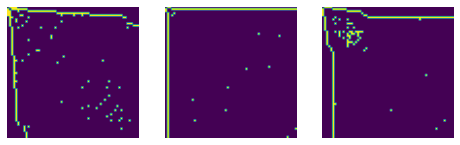

In [166]:
showImages([s.adj().to_dense() for s in samples])

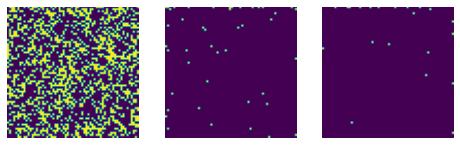

In [162]:
showImages([sampled_images.squeeze()[i].cpu() > 0.5 for i in range(len(samples))])